In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

df = pd.read_csv("/content/logs.csv")

In [2]:
df.head()

,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [3]:
df.source.unique()

array(['ModernCRM', 'AnalyticsEngine', 'ModernHR', 'BillingSystem',
       'ThirdPartyAPI', 'LegacyCRM'], dtype=object)

In [4]:
df.target_label.unique()

array(['HTTP Status', 'Critical Error', 'Security Alert', 'Error',
       'System Notification', 'Resource Usage', 'User Action',
       'Workflow Error', 'Deprecation Warning'], dtype=object)

In [5]:
#embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['log_message'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
embeddings[:5]

array([[-0.1029396 ,  0.03354595, -0.02202608, ...,  0.00457793,
        -0.04259716,  0.00322623],
       [ 0.00804573, -0.03573924,  0.04938739, ...,  0.01538321,
        -0.06230951, -0.02774664],
       [-0.00908221,  0.13003927, -0.05275569, ...,  0.02014104,
        -0.05117096, -0.02930295],
       [-0.09751045,  0.04911302, -0.03977428, ...,  0.02477501,
        -0.03546082, -0.00018599],
       [-0.10468338,  0.05926034, -0.02488501, ...,  0.02502053,
        -0.03719296, -0.02568914]], dtype=float32)

In [7]:
#DBSCAN

dbs = DBSCAN(eps=0.2, min_samples=1, metric='cosine')
clusters = dbs.fit_predict(embeddings)

df['cluster'] = clusters

In [8]:
df.head()
df[df.cluster==1]
df.head()

,timestamp,source,log_message,target_label,complexity,cluster
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0


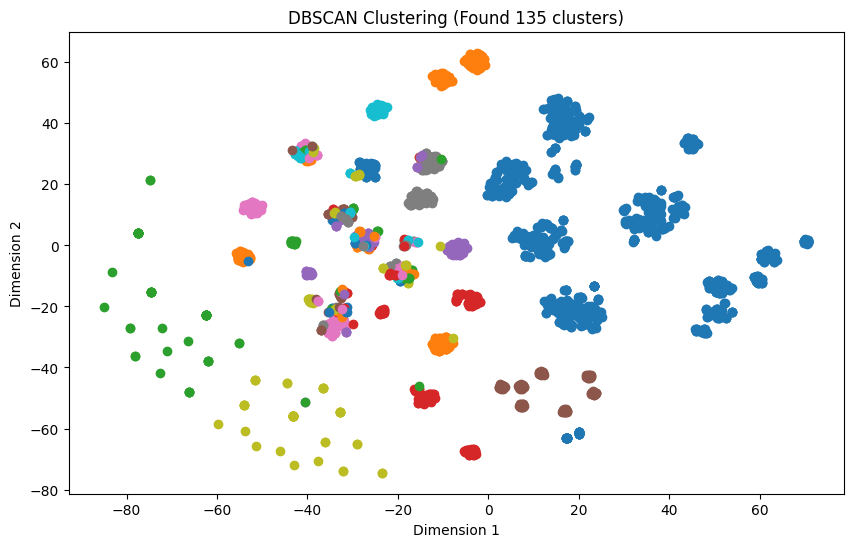

In [9]:
#Reduce dimensions to 2D for visualization

tsne = TSNE(n_components=2, random_state=42)
points_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))

for cluster_num in set(clusters):
    # Get points for this cluster
    mask = (clusters == cluster_num)

    if cluster_num == -1:  #Noise
        plt.scatter(points_2d[mask, 0], points_2d[mask, 1],
                    c='gray', label='Noise', alpha=0.5)
    else:  #Regular clusters
        plt.scatter(points_2d[mask, 0], points_2d[mask, 1],
                    label=f'Cluster {cluster_num}')

plt.title(f"DBSCAN Clustering (Found {len(set(clusters))-1} clusters)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [10]:
df[df.cluster==1]
df.head()

,timestamp,source,log_message,target_label,complexity,cluster
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0


In [11]:
cluster_counts = df['cluster'].value_counts()
large_clusters = cluster_counts[cluster_counts >10].index

for cluster in large_clusters:
  print(f"Cluster{cluster}:")
  print(df[df['cluster'] == cluster]['log_message'].head(5).to_string(index=False))

Cluster0:
nova.osapi_compute.wsgi.server [req-b9718cd8-f6...
nova.osapi_compute.wsgi.server [req-4895c258-b2...
nova.osapi_compute.wsgi.server [req-ee8bc8ba-92...
nova.osapi_compute.wsgi.server [req-f0bffbc3-5a...
nova.osapi_compute.wsgi.server [req-2bf7cfee-a2...
Cluster5:
nova.compute.claims [req-a07ac654-8e81-416d-bfb...
nova.compute.claims [req-d6986b54-3735-4a42-907...
nova.compute.claims [req-72b4858f-049e-49e1-b31...
nova.compute.claims [req-5c8f52bd-8e3c-41f0-95a...
nova.compute.claims [req-d38f479d-9bb9-4276-968...
Cluster11:
User User685 logged out.
 User User395 logged in.
 User User225 logged in.
User User494 logged out.
 User User900 logged in.
Cluster13:
Backup started at 2025-05-14 07:06:55.
Backup started at 2025-02-15 20:00:19.
  Backup ended at 2025-08-08 13:06:23.
Backup started at 2025-11-14 08:27:43.
Backup started at 2025-12-09 10:19:11.
Cluster7:
Multiple bad login attempts detected on user 85...
Multiple login failures occurred on user 9052 a...
  User 7153 made

In [17]:
import re
def classify_with_regex(log_message):
    regex_patterns = {
        r"User User\d+ logged (in|out).": "User Action",
        r"Backup (started|ended) at .*": "System Notification",
        r"Backup completed successfully.": "System Notification",
        r"System updated to version .*": "System Notification",
        r"File .* uploaded successfully by user .*": "System Notification",
        r"Disk cleanup completed successfully.": "System Notification",
        r"System reboot initiated by user .*": "System Notification",
        r"Account with ID .* created by .*": "User Action"
    }
    for pattern, label in regex_patterns.items():
        if re.search(pattern, log_message, re.IGNORECASE):
            return label
    return None

In [18]:
result = classify_with_regex("User User494 logged OUT.")
print(result)

User Action


In [26]:
df.shape

(2410, 7)

In [27]:
df['regex_label'] = df['log_message'].apply(classify_with_regex)
df[df.regex_label.isna()]

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None
...,...,...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,0,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,7,None
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,0,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1,None


In [28]:
df[df.regex_label.notnull()]

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
7,10/11/2025 8:44,ModernHR,File data_6169.csv uploaded successfully by us...,System Notification,regex,4,System Notification
14,1/4/2025 1:43,ThirdPartyAPI,File data_3847.csv uploaded successfully by us...,System Notification,regex,4,System Notification
15,5/1/2025 9:41,ModernCRM,Backup completed successfully.,System Notification,regex,8,System Notification
18,2/22/2025 17:49,ModernCRM,Account with ID 5351 created by User634.,User Action,regex,9,User Action
27,9/24/2025 19:57,ThirdPartyAPI,User User685 logged out.,User Action,regex,11,User Action
...,...,...,...,...,...,...,...
2376,6/27/2025 8:47,ModernCRM,System updated to version 2.0.5.,System Notification,regex,21,System Notification
2381,9/5/2025 6:39,ThirdPartyAPI,Disk cleanup completed successfully.,System Notification,regex,32,System Notification
2394,4/3/2025 13:13,ModernHR,Disk cleanup completed successfully.,System Notification,regex,32,System Notification
2395,5/2/2025 14:29,ThirdPartyAPI,Backup ended at 2025-05-06 11:23:16.,System Notification,regex,13,System Notification


In [30]:
df_non_regex = df[df['regex_label'].isna()].copy()
df_non_regex

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None
...,...,...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,0,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,7,None
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,0,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1,None


In [35]:
print(df_non_regex['target_label'].value_counts())

rare_categories = df_non_regex['target_label'].value_counts()[df_non_regex['target_label'].value_counts() <= 5].index.tolist()
print(rare_categories)

target_label
HTTP Status            1017
Security Alert          371
Error                   177
Resource Usage          177
Critical Error          161
Workflow Error            4
Deprecation Warning       3
Name: count, dtype: int64
['Workflow Error', 'Deprecation Warning']


In [44]:
df_non_legacy = df_non_regex[df_non_regex.source!='LegacyCRM']


In [45]:
df_non_legacy.source.unique()

array(['ModernCRM', 'AnalyticsEngine', 'ModernHR', 'BillingSystem',
       'ThirdPartyAPI'], dtype=object)

In [47]:
#embeddings for Bert for encoding

filtered_embeddings = model.encode(df_non_legacy['log_message'].tolist())

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
X = filtered_embeddings
y = df_non_legacy['target_label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       0.98      0.89      0.93        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      0.99      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571



In [55]:
import joblibx`
joblib.dump(clf,'/content/sample_data/log_classification.joblib')


['/content/sample_data/log_classification.joblib']